# Indoor localization using deep learning with DNN and KNN

## 1. Importing the packages

In [334]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import torch
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import geopy.distance
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## 2. Importing the data

### 2.1. UJIIndoorLoc dataset
* Dataset: UJIIndoorLoc (https://archive.ics.uci.edu/ml/datasets/ujiindoorloc)
* 529 attributes and 19937 rows

In [2]:
# UJIIndoorloc dataset
dataset_ujloc = pd.read_csv("../data_UJIndoorLoc/trainingData.csv")
validation_dataset_ujloc = pd.read_csv("../data_UJIndoorLoc/validationData.csv")
dataset_ujloc.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [3]:
# print(dataset.shape)
# print(dataset[dataset['BUILDINGID'] == 0].shape)
# print(dataset[dataset['BUILDINGID'] == 1].shape)
# print(dataset[dataset['BUILDINGID'] == 2].shape)
dataset_ujloc = dataset_ujloc[dataset_ujloc['BUILDINGID'] == 2]
validation_dataset_ujloc = validation_dataset_ujloc[validation_dataset_ujloc['BUILDINGID'] == 2]

### 2.2. PrecisLoc dataset

In [4]:
# PrecisLoc dataset
dataset_dir = "../data_PrecisLoc/FINAL_PRECISLOC_DATASET"
dataset_scen_1 = os.path.join(dataset_dir, "Scenario_1", "11-05-07")
dataset_scen_1

'../data_PrecisLoc/FINAL_PRECISLOC_DATASET\\Scenario_1\\11-05-07'

In [5]:
for filename in os.listdir(dataset_scen_1):
    if filename.startswith("Sensor"):
        sensor_readings = filename
    if filename.startswith("ground"):
        ground_truth = filename

print(sensor_readings)
print(ground_truth)

Sensor_readings_11-05-07.xml
ground_truth_11-05-07.xml


In [6]:
sensor_read_scen_1 = os.path.join(dataset_scen_1, sensor_readings)
ground_truth_scen_1 = os.path.join(dataset_scen_1, ground_truth)
sensor_read_scen_1

'../data_PrecisLoc/FINAL_PRECISLOC_DATASET\\Scenario_1\\11-05-07\\Sensor_readings_11-05-07.xml'

In [7]:
# Getting the unique MAC addresses of APs
tree = ET.parse(sensor_read_scen_1)

ap_list = [] 
for r in tree.iter(tag='r'):
    ap_list.append(r.attrib['b'])

ap_set = set(ap_list)
ap_set

{'32:cd:a7:a0:6d:d8',
 '84:b2:61:40:75:f0',
 '84:b2:61:40:75:f1',
 '84:b2:61:40:75:f2',
 '84:b2:61:47:dd:40',
 '84:b2:61:47:dd:41',
 '84:b2:61:47:dd:42',
 '84:b2:61:47:dd:4d',
 '84:b2:61:47:dd:4e',
 '84:b2:61:47:dd:4f',
 '84:b2:61:47:e2:c0',
 '84:b2:61:47:e2:c1',
 '84:b2:61:47:e2:c2',
 '84:b2:61:47:e2:cd',
 '84:b2:61:47:e2:ce',
 '84:b2:61:56:8a:00',
 '84:b2:61:56:8a:01',
 '84:b2:61:56:8a:02',
 '84:b2:61:56:8a:0d',
 '84:b2:61:56:8a:0e',
 '84:b2:61:56:8a:0f',
 '84:b2:61:5e:44:20',
 '84:b2:61:5e:44:21',
 '84:b2:61:5e:44:22',
 '84:b2:61:5e:44:2d',
 '84:b2:61:5e:44:2e',
 '84:b2:61:5e:44:2f',
 '84:b2:61:6d:3d:20',
 '84:b2:61:6d:3d:21',
 '84:b2:61:6d:3d:22',
 '84:b2:61:6d:3d:2d',
 '84:b2:61:6d:3d:2e',
 '84:b2:61:6d:3d:2f',
 '84:b2:61:6d:52:a0',
 '84:b2:61:6d:52:a1',
 '84:b2:61:6d:52:a2',
 '84:b2:61:6d:52:af',
 '84:b2:61:6d:5d:70',
 '84:b2:61:6d:5d:71',
 '84:b2:61:6d:5d:72',
 'c4:71:54:39:70:e4'}

In [8]:
# Reading the Sensor Readings for the scenario 1, 11-05-07
tree = ET.parse(sensor_read_scen_1)

time_data_ap_dict = {}

for wr in tree.iter(tag = 'wr'):
    time_data_ap_dict[wr.attrib['st']] = wr.iter(tag='r')

# for key in time_data_dict:
#     print(key, ': ', time_data_dict[key])
#     for r in time_data_dict[key]:
#         print(r.attrib)
time_data_ap_dict

{'11:05:09:00': <_elementtree._element_iterator at 0x2433df17d60>,
 '11:05:10:00': <_elementtree._element_iterator at 0x2433df17d10>,
 '11:05:11:00': <_elementtree._element_iterator at 0x2433df17cc0>,
 '11:05:12:00': <_elementtree._element_iterator at 0x2433df17bd0>,
 '11:05:13:00': <_elementtree._element_iterator at 0x2433df17b30>,
 '11:05:14:00': <_elementtree._element_iterator at 0x2433df17a90>,
 '11:05:17:00': <_elementtree._element_iterator at 0x2433df179f0>,
 '11:05:20:00': <_elementtree._element_iterator at 0x2433df17950>,
 '11:05:21:00': <_elementtree._element_iterator at 0x2433df17810>,
 '11:05:22:00': <_elementtree._element_iterator at 0x2433df17f90>,
 '11:05:23:00': <_elementtree._element_iterator at 0x2433df17770>,
 '11:05:24:00': <_elementtree._element_iterator at 0x2433df176d0>,
 '11:05:25:00': <_elementtree._element_iterator at 0x2433df17590>,
 '11:05:26:00': <_elementtree._element_iterator at 0x2433df178b0>,
 '11:05:27:00': <_elementtree._element_iterator at 0x2433df174

In [9]:
# Reading the Ground Truth for the scenario 1, 11-05-07
tree1 = ET.parse(ground_truth_scen_1)

time_location_dict = {}

for position in tree1.iter(tag = 'position'):
#     print(position.attrib['time'].split(':')[:-1])
    time_location_dict[position.attrib['time']] = position.attrib
time_location_dict

{'11:05:09:000': {'lat': '44.434918',
  'long': '26.047606',
  'time': '11:05:09:000'},
 '11:05:10:600': {'lat': '44.43491799999931',
  'long': '26.047618594726657',
  'time': '11:05:10:600'},
 '11:05:11:600': {'lat': '44.43491799999862',
  'long': '26.047631189453316',
  'time': '11:05:11:600'},
 '11:05:12:400': {'lat': '44.43491799999792',
  'long': '26.047643784179975',
  'time': '11:05:12:400'},
 '11:05:13:200': {'lat': '44.434917999997225',
  'long': '26.047656378906634',
  'time': '11:05:13:200'},
 '11:05:14:100': {'lat': '44.43491799999653',
  'long': '26.047668973633293',
  'time': '11:05:14:100'},
 '11:05:17:500': {'lat': '44.43491799999584',
  'long': '26.047681568359952',
  'time': '11:05:17:500'},
 '11:05:20:000': {'lat': '44.43491799999566',
  'long': '26.04768786572328',
  'time': '11:05:20:000'},
 '11:05:21:100': {'lat': '44.434909006779606',
  'long': '26.04768786572328',
  'time': '11:05:21:100'},
 '11:05:21:950': {'lat': '44.43490001356355',
  'long': '26.047687865723

In [10]:
dict_for_df = {'lat': [],
               'long': [],
               'timestamp': []}

for timestamp, location in time_location_dict.items():
#     print('key: ', timestamp, ', location:', location)
    pass

## 3. Data vizualisation

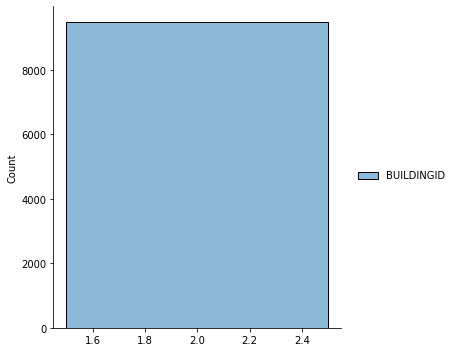

In [11]:
# Making the bar chart for buildings
sns.displot(dataset_ujloc[['BUILDINGID']], kde=False)

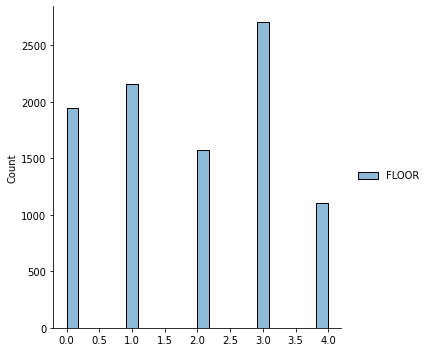

In [12]:
# Making the bar chart for floors
sns.displot(dataset_ujloc[['FLOOR']],kde=False)

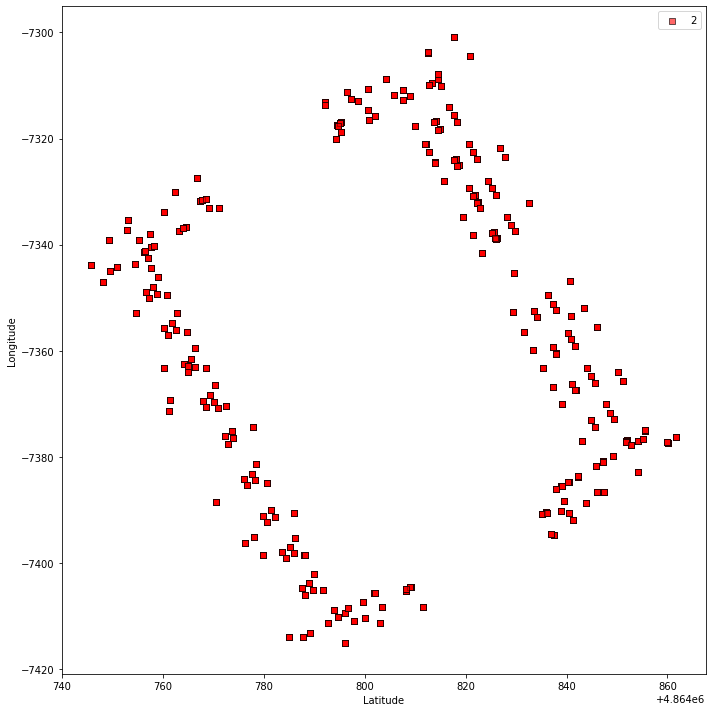

In [13]:
# The scatter plot of the available data points
markers = ('s', 'X', 'o')
colors = ('red', 'yellow', 'lightgreen')
cmap = ListedColormap(colors[:len(np.unique(dataset_ujloc['BUILDINGID']))])


fig = plt.figure(figsize=(10,10))
for idx, cl in enumerate(np.unique(dataset_ujloc['BUILDINGID'])):
        plt.scatter(x=dataset_ujloc.loc[dataset_ujloc.BUILDINGID== cl]['LATITUDE'], 
                    y=dataset_ujloc.loc[dataset_ujloc.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()

<AxesSubplot:xlabel='FLOOR', ylabel='count'>

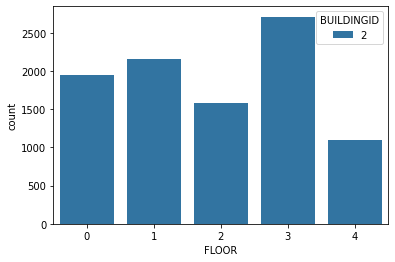

In [14]:
# Buildings 0/1 have 4 floors, building 2 has 5
sns.countplot(x="FLOOR", hue="BUILDINGID", data=dataset_ujloc, orient="v")

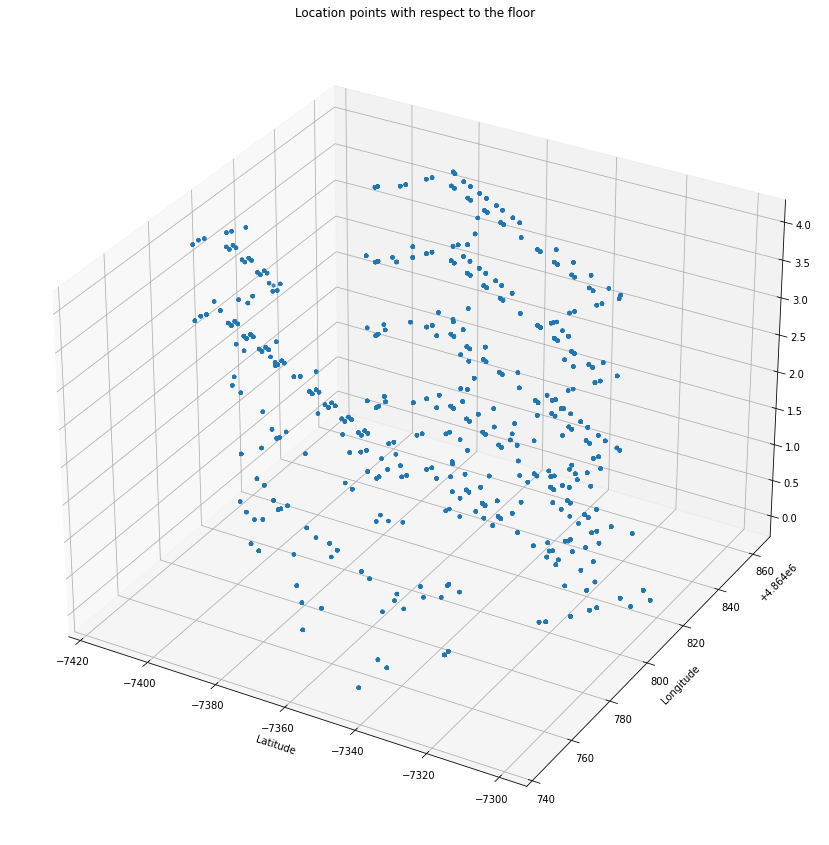

In [15]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
xs = dataset_ujloc['LONGITUDE']
ys = dataset_ujloc['LATITUDE']
zs = dataset_ujloc['FLOOR']
ax.scatter(xs, ys, zs, alpha=0.5, s=10,marker='o')

plt.title("Location points with respect to the floor")

plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.show()

## 4. Data preprocessing

In [16]:
# Removing the unused columns
dataset_ujloc.drop(["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"], axis=1, inplace=True)
validation_dataset_ujloc.drop(["SPACEID", "RELATIVEPOSITION", "USERID", "PHONEID", "TIMESTAMP"], axis=1, inplace=True)

In [17]:
dataset_ujloc.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
46,100,100,100,100,100,100,100,100,100,100,...,100,100,-93,100,100,100,-7331.748000,4.864767e+06,3,2
47,100,100,100,100,100,100,100,100,100,100,...,100,100,-89,100,100,100,-7331.400500,4.864768e+06,3,2
49,100,100,100,100,100,100,100,100,100,100,...,100,100,100,-91,100,100,-7327.492165,4.864767e+06,3,2
50,100,100,100,100,100,100,100,100,100,100,...,100,100,-90,100,100,100,-7336.700400,4.864764e+06,3,2
51,100,100,100,100,100,100,100,100,100,100,...,100,100,-92,100,100,100,-7337.394800,4.864763e+06,3,2


### 4.1. Dropping BUILDINGID for cases where we train on a single building

In [18]:
# Removing the building (for scenario with only a building selected)
# dataset_ujloc.drop(["BUILDINGID"], axis=1, inplace=True)
# validation_dataset_ujloc.drop(["BUILDINGID"], axis=1, inplace=True)

In [19]:
# dataset_ujloc.head(5)

### 4.2. Encoding a POINT column (FLOOR+BUILDINGID) for cases of multi-building classification

In [20]:
# Creating the output (target) column for DNN (For the case of FLOOR+Building // otherwise, just floor is enough (for only 1 building seleted))
# dataset_ujloc['POINT'] = dataset_ujloc['FLOOR'].astype(str) + dataset_ujloc['BUILDINGID'].astype(str)
# validation_dataset_ujloc['POINT'] = validation_dataset_ujloc['FLOOR'].astype(str) + \
#                                     validation_dataset_ujloc['BUILDINGID'].astype(str)

In [21]:
# dataset_ujloc.head(5)

In [22]:
# Encoding the FLOOR+BUILDING (=POINT)
# floor_build_encoder = LabelEncoder()
# floor_build_encoder.fit(dataset_ujloc["POINT"])

In [23]:
# floor_build_encoder = floor_build_encoder.transform(dataset_ujloc['POINT'])

In [24]:
# df_point_encoded = pd.DataFrame(floor_build_encoder, columns=['POINT_ENCODED'])

In [25]:
# dataset_ujloc = pd.concat([dataset_ujloc, df_point_encoded], axis=1)

In [26]:
# dataset_ujloc

## ----------------------- Up until here the dataset and validation are the same -------------------

### 4.3. Splitting the data in labels and targets for the first DNN (Step 1)

In [27]:
X = dataset_ujloc.iloc[:, :520].values
y = dataset_ujloc['FLOOR'].values

In [28]:
X

array([[100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., -91, 100, 100],
       ...,
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100]], dtype=int64)

In [29]:
y

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

### 4.4. Splitting the dataset into Training and Test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [31]:
X_train

array([[100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       ...,
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100]], dtype=int64)

### 4.5. Feature scaling

In [32]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # mean and std of the values in training set in order to fit the scaler to  the train set
X_test = sc.transform(X_test) # only transform, because if we'd fit again, we'd have information leackage

In [33]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.05138192, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05138192, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05138192, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05138192, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05138192, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05138192, 0.        ,
        0.        ]])

In [34]:
y_train

array([2, 4, 1, ..., 2, 0, 1], dtype=int64)

## 5. Building the first DNN model

### 5.1. Initializing the NN

In [35]:
 nn = tf.keras.models.Sequential()

### 5.2. Adding the input layer and the first hidden layer

In [36]:
# Adding a fully-connected layer (it automatically create the input layer)
# num of neurons = num of features (520 APs)
input_size = 520
nn.add(tf.keras.layers.Dense(input_dim=input_size, units=256, activation='relu'))

### 5.3. Adding the second layer

In [37]:
# Adding a layer with 128 neurons
nn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### 5.4. Adding the output layer

In [38]:
# fotmax for > 2 categories
classes = 5
nn.add(tf.keras.layers.Dense(units=classes, activation='softmax'))

## 6. Training the DNN

### 6.1. Compiling the DNN

In [39]:
# Optimizer = Adam ==> Stochastic Gradient Descent
nn.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics = ['accuracy'])

### 6.2. Training the ANN on the Training set

In [40]:
# batch_size for speeding up the trainings (the most used is 32)
nn.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
238/238 [==============================] - 2s 5ms/step - loss: 0.2550 - accuracy: 0.9176
Epoch 2/20
238/238 [==============================] - 1s 5ms/step - loss: 0.0630 - accuracy: 0.9795
Epoch 3/20
238/238 [==============================] - 1s 4ms/step - loss: 0.0395 - accuracy: 0.9876
Epoch 4/20
238/238 [==============================] - 1s 4ms/step - loss: 0.0254 - accuracy: 0.9908
Epoch 5/20
238/238 [==============================] - 1s 4ms/step - loss: 0.0163 - accuracy: 0.9947
Epoch 6/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0095 - accuracy: 0.9972
Epoch 7/20
238/238 [==============================] - 1s 5ms/step - loss: 0.0083 - accuracy: 0.9982
Epoch 8/20
238/238 [==============================] - 1s 4ms/step - loss: 0.0040 - accuracy: 0.9992
Epoch 9/20
238/238 [==============================] - 1s 3ms/step - loss: 0.0038 - accuracy: 0.9992
Epoch 10/20
238/238 [==============================] - 1s 4ms/step - loss: 0.0032 - accuracy: 0.9988

## 7. Making predictions and evaluating the model

### 7.1. Predicting the Test set results

In [41]:
y_pred = nn.predict(X_test)

60/60 [==============================] - 0s 3ms/step


In [42]:
y_pred

array([[4.3840978e-18, 8.3204211e-16, 7.9009256e-12, 1.0000000e+00,
        1.7256337e-09],
       [1.4654345e-15, 1.9788668e-16, 6.0346566e-15, 7.6027686e-07,
        9.9999928e-01],
       [9.3900937e-21, 2.1107834e-22, 3.8887524e-17, 1.0000000e+00,
        1.0252426e-11],
       ...,
       [1.9589272e-12, 1.0295450e-12, 2.1587368e-06, 9.9999785e-01,
        9.9465236e-09],
       [1.0000000e+00, 2.8516752e-08, 3.8665628e-14, 2.8490738e-10,
        1.1994041e-09],
       [1.5391736e-19, 5.6100423e-18, 5.5947708e-11, 1.0000000e+00,
        1.6774943e-12]], dtype=float32)

In [43]:
y_pred.shape

(1899, 5)

#### 7.1.1. Transforming the encoded data back to floor number

In [44]:
# we transform  the (1899, 5) floor array back to single value (the number of the floor)

# floor_pred = []
# floors = [i for i in range(5)]
# for arr in y_pred:
#     max_val = max(arr)
#     index_max = np.where(arr == max_val)
#     floor_pred.append(floors[index_max[0][0]])
# floor_pred = np.array(floor_pred)

floor_pred = tf.argmax(y_pred, axis=1)
floor_pred = tf.keras.backend.eval(floor_pred)

In [45]:
floor_pred

array([3, 4, 3, ..., 3, 0, 3], dtype=int64)

In [46]:
y_test

array([3, 4, 3, ..., 3, 0, 3], dtype=int64)

### 7.2. Making the confusion matrix and calculating Accuracy 

In [47]:
cm = confusion_matrix(y_test, floor_pred)
print(cm)
accuracy = accuracy_score(y_test, floor_pred)
print('Accuracy: ', accuracy)

[[403   3   0   0   0]
 [  4 411   3   0   0]
 [  1  11 281   7   0]
 [  0   0   3 557   1]
 [  0   0   0   2 212]]
Accuracy:  0.9815692469720906


### 7.3. Predicting with the Validation set

In [48]:
X_valid = validation_dataset_ujloc.iloc[:, :520].values
y_valid = validation_dataset_ujloc['FLOOR'].values

In [49]:
X_valid = sc.fit_transform(X_valid)

In [50]:
y_pred_valid = nn.predict(X_valid)
y_pred_valid

9/9 [==============================] - 0s 2ms/step


array([[1.09115612e-10, 1.60560627e-16, 6.54958333e-14, 5.06087005e-01,
        4.93912995e-01],
       [7.24359669e-11, 2.80072953e-16, 9.88194429e-17, 7.43267421e-08,
        9.99999881e-01],
       [2.52198173e-15, 5.64293385e-22, 2.27904948e-20, 2.12843307e-08,
        1.00000000e+00],
       ...,
       [9.55261044e-08, 3.33329336e-10, 1.57149123e-06, 9.99997854e-01,
        5.20536901e-07],
       [8.83748456e-12, 1.60931581e-11, 3.47135043e-10, 1.00000000e+00,
        1.00424495e-08],
       [1.21441676e-10, 2.72329248e-09, 1.74808168e-08, 9.99999881e-01,
        1.32430998e-07]], dtype=float32)

In [51]:
y_pred_valid.shape

(268, 5)

In [52]:
floor_pred_valid = tf.argmax(y_pred_valid, axis=1)
floor_pred_valid = tf.keras.backend.eval(floor_pred_valid)

In [53]:
floor_pred_valid

array([3, 4, 4, 2, 3, 3, 3, 0, 3, 0, 0, 2, 0, 1, 4, 0, 1, 4, 4, 1, 2, 3,
       3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 3, 2,
       2, 2, 2, 1, 3, 1, 1, 4, 1, 3, 3, 1, 1, 3, 4, 1, 1, 1, 1, 1, 3, 2,
       1, 1, 4, 1, 3, 1, 4, 3, 3, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 2, 1,
       1, 4, 1, 1, 0, 3, 1, 1, 1, 4, 1, 3, 1, 1, 1, 4, 3, 1, 1, 4, 3, 0,
       0, 4, 1, 1, 2, 1, 3, 0, 4, 3, 2, 1, 4, 2, 1, 2, 0, 2, 2, 2, 1, 3,
       2, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 3, 1, 4, 1, 2, 2, 2, 0, 3, 2, 2,
       2, 1, 3, 2, 2, 4, 1, 1, 3, 1, 2, 4, 1, 2, 2, 4, 3, 2, 0, 2, 3, 3,
       3, 2, 0, 1, 3, 2, 3, 1, 1, 2, 2, 3, 1, 0, 2, 4, 4, 1, 1, 4, 1, 4,
       1, 0, 4, 1, 1, 1, 1, 4, 0, 0, 1, 4, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3], dtype=int64)

In [54]:
cm = confusion_matrix(y_valid, floor_pred_valid)
print(cm)
accuracy = accuracy_score(y_valid, floor_pred_valid)
print('Accuracy: ', accuracy)

[[22  2  0  0  0]
 [ 6 96  8  1  0]
 [ 0  3 36 15  0]
 [ 0  0  0 37  3]
 [ 1  0  0 11 27]]
Accuracy:  0.8134328358208955


## 8. Building the KNN regressor

### 8.1. Creating the second training dataset

#### 8.1.1. Selecting the cluster to which out values correspond to (the Floor)

In [415]:
floor = 3
# floor = floor_pred_valid[0] # TODO: verify how can we change this so it gets the floor by default
mask = dataset_ujloc['FLOOR'] == floor

In [416]:
df_ap = dataset_ujloc.iloc[:, :520][mask]
df_floor = dataset_ujloc['FLOOR'][mask]

In [417]:
X_step_2 = pd.concat([df_ap, df_floor], axis=1).values
y_step_2 = dataset_ujloc[['LONGITUDE', 'LATITUDE']][mask].values

In [418]:
X_step_2

array([[100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3],
       ...,
       [100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3]], dtype=int64)

In [419]:
y_step_2

array([[  -7331.748     , 4864767.318     ],
       [  -7331.4005    , 4864768.4786    ],
       [  -7327.49216509, 4864766.66853056],
       ...,
       [  -7373.0528    , 4864844.8865    ],
       [  -7390.4354    , 4864835.897     ],
       [  -7394.57782488, 4864836.92470566]])

### 8.3. Splitting the data in Train and Test

In [420]:
X_train_step_2, X_test_step_2, y_train_step_2, y_test_step_2 = train_test_split(X_step_2,
                                                                                y_step_2, 
                                                                                test_size = 0.2, 
                                                                                random_state = 0)

In [421]:
X_train_step_2

array([[100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3],
       ...,
       [100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3],
       [100, 100, 100, ..., 100, 100,   3]], dtype=int64)

In [422]:
len(X_train_step_2)

2167

### 8.4. Building the model

In [476]:
knn_regressor = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_regressor.fit(X_train_step_2, y_train_step_2)

KNeighborsRegressor(n_neighbors=3, weights='distance')

### 8.5. Making predictions and evaluating the model

In [488]:
y_pred_step_2 = knn_regressor.predict(X_test_step_2)
y_pred_step_2

array([[  -7373.82773854, 4864852.32047202],
       [  -7314.86429868, 4864809.96847438],
       [  -7377.0397859 , 4864844.6256713 ],
       ...,
       [  -7391.3591    , 4864782.1517    ],
       [  -7376.87215518, 4864852.89278434],
       [  -7407.44802253, 4864789.43363006]])

In [489]:
y_pred_step_2.shape

(542, 2)

In [490]:
y_test_step_2.shape

(542, 2)

In [491]:
print(mean_squared_error(y_pred_step_2, y_test_step_2))

11.974727667219259


In [492]:
y_pred_step_2 = pd.DataFrame(y_pred_step_2, columns=['long1', 'lat1'])
y_test_step_2 = pd.DataFrame(y_test_step_2, columns=['long2', 'lat2'])
# alculating the Euclidian distance between points
distance_df = pd.DataFrame((y_test_step_2['lat2']-y_pred_step_2['lat1'])**2 + 
                           (y_test_step_2['long2']-y_pred_step_2['long1'])**2)**(1/2)
sum_dist = distance_df.sum()
mean_error = sum_dist/len(distance_df)
mean_error

0    2.838891
dtype: float64

In [493]:
# from math import sin, cos, sqrt, atan2, radians

# # Approximate radius of earth in km
# R = 6373.0

# def calc_dist(lat1, lon1, lat2, lon2):
#     lat1 = radians(lat1)
#     lon1 = radians(lon1)
#     lat2 = radians(lat2)
#     lon2 = radians(lon2)

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c
#     return distance

# print("Result: ", distance)
# print("Should be: ", 278.546, "km")

In [494]:
df_final = pd.DataFrame()
df_final = pd.concat([y_pred_step_2, y_test_step_2], axis=1)
df_final

,long1,lat1,long2,lat2
0,-7373.827739,4.864852e+06,-7380.934600,4.864847e+06
1,-7314.864299,4.864810e+06,-7312.662200,4.864808e+06
2,-7377.039786,4.864845e+06,-7374.347500,4.864846e+06
3,-7386.709566,4.864847e+06,-7388.263861,4.864840e+06
4,-7344.496730,4.864750e+06,-7344.968400,4.864750e+06
...,...,...,...,...
537,-7336.299000,4.864829e+06,-7336.299000,4.864829e+06
538,-7325.052900,4.864819e+06,-7325.052900,4.864819e+06
539,-7391.359100,4.864782e+06,-7391.359100,4.864782e+06
540,-7376.872155,4.864853e+06,-7381.754700,4.864846e+06


In [495]:
# earth_radius=6371

# df_final['long1'] = np.radians(df_final['long1'])
# df_final['long2'] = np.radians(df_final['long2'])
# df_final['lat1'] = np.radians(df_final['lat1'])
# df_final['lat2'] = np.radians(df_final['lat2'])


# df_final['a'] = np.sin((df_final['lat2']-df_final['lat1'])/2.0)**2 + \
#     np.cos(df_final['lat1']) * np.cos(df_final['lat2']) * np.sin((df_final['long2']-df_final['long1'])/2.0)**2

# df_final['DISTANCE'] = earth_radius * 2 * np.arcsin(np.sqrt(df_final['a']))
# dist_km = df_final['DISTANCE'].sum().mean()
# dist_m = dist_km
# dist_m

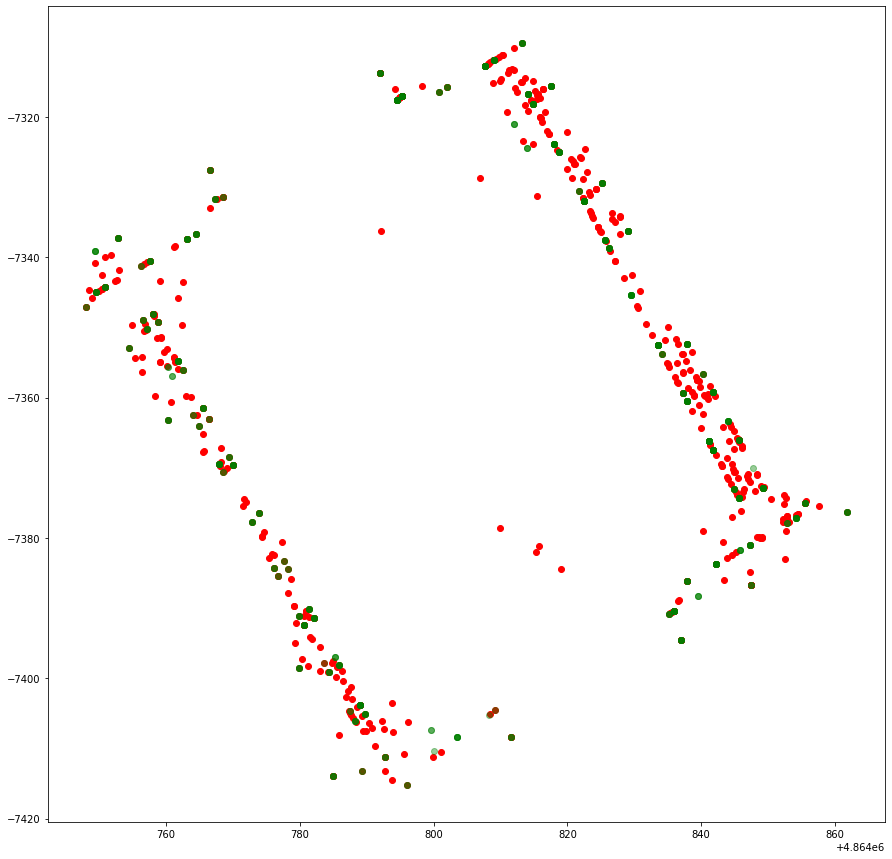

In [499]:
plt.figure(figsize=(15,15))
plt.scatter(df_final['lat1'], df_final['long1'], color='red')
plt.scatter(df_final['lat2'], df_final['long2'], color='green', alpha=0.4)